# Context Function

## Introduction

This document explains and builds a context function. The purpose of the context function is to determine when two nouns are likely used in a different context for a given adjective. For example, given the adjective "hot", and the nouns "woman" and "stove", we recognize that a different definition is likely implied for each noun. Specifically, if hot is used to describe stove, we assume hot is meant to refer to the stove's temperature. On the other hand, if hot is used to describe "woman", we assume hot is meant as physically attractive.

The context function takes two nouns and an adjective and makes a prediction of whether the adjective is likely used in the same context for the two nouns, or in a different context. Determining context is known as "word sense disambiguation" (wsd). Usually, wsd involves a word to be disambiguated, along with a sentence that can help determine the context of the word. In our case, the sentence is comprised of only two words, the noun and the adjective. This makes our task more difficult or, perhaps, more ambiguous since our lack of contextual information may not be enough to determine context. For instance, if we consider the noun "meal" and the adjective "hot", it is not entirely clear whether hot refers to the temperature or spiciness of the meal. What we are looking to accomplish with this method is an "intuition" of the context. To gain an "intuition" of the context, we will use a statistical approach.

The standard method for this task uses the Lesk algorithm, and is available in the NLTK package. NLTK's lesk function takes two arguments, a sentence and a word to disambiguate. The input sentence contains the word to be disambiguated as well as other words that put the word into context. In our case, we only have a two word sentence, composed of the adjective and the noun. The lesk function returns a predicted synset (the details of how the lesk algorithm works will not be covered). A context function that determines if an adjective is likely used in the same context when paired with two different nouns can be created by comparing the two outputs of the lesk function for each noun (paired with the adjective). Unfortunately, in our case, this method has been determined to be no more successful than random guessing. Furthermore, the context function using the lesk function is biased towards predicting the adjective is used in different contexts (positive prediction) for the two nouns. This happens because the function returns a particular definition, and the more definitions an adjective has, the more likely the function will return a different definition for each noun. 

Our method attempts to improve over the standard lesk method, by using a statistical approach and avoids the bias introduced from adjectives that have many definitions. As mentioned previously, we want to match a definition of an adjective to a noun using a statistical method. We do this by measuring how well the noun is collocated to each word in a definition. Multiple collocation scores can be used. Then the entire definition is given a total score (again, there are several ways to compute a total score, such as average, sum, etc.). The definition scores are designed to have a positive correlation with the likelyhood that that definition is the correct context.

Each noun has an associated list of scores, one score for each definition. To determine if the two nouns are used in different contexts, the score lists are compared, and a "feature score" is derived. The feature score will be used as a feature in a machine learning model. The feature is derived so that a high value predicts different context, and a low value predicts same context (i.e. all features will be designed so that they are positively correlated with the "different context" prediction). As with the definition scores, there are multiple ways to derive a feature score from the two lists, and all are based on intuition. For example, if the definition score list for a particular noun has multiple non zero values, we interpret this as uncertainty in acertaining the correct definition and should lead to a low score (erring on the side of predicting same context). On the other hand, if the two score lists have only one non zero definition score, and they are for different definitions, this is a good indication that the context is different.

The exact scoring techniques will be explained in more detail below. We will take a step by step approach to building our model with explanations along the way.

Using this scoring method allows us to create an unsupervised method for predicting whether the adjective is used in same context or different context for the two nouns. All we need to do is find a method of combining all features into one score. Since all features are meant to be positively correlated with a different context prediction, we may combine the scores in several different ways, such as a weighted or non weighted sum, the average, the product, etc. However, since we don't know how best to weight each feature score, we will use a supervised approach to determine the weights.

A labeled data set has been constructed to be used as a train set for machine learning techniques. The train set was constructed by myself, and is, admittedly biased. However, this bias is not necessarily a bad thing...it allows the user to tailor the results to his own intuition or need. The train set (pandas dataframe) has a column of samples and a column of targets. The samples are 3-tuples in the form (noun1, noun2, adjective). The target value is 1 if the adjective is considered used in different contexts for the two nouns and a 0 if the adjective is used in the same context.

Once the feature set has been created for the labeled training data, a random forrest model will be trained and evaluated. Other machine learning models have been tested on the training data, but have yielded inferior results (especially in the case of linear models), or similar results and will not be reproduced in this document. 

## The Imports

In [18]:
import pandas as pd
import nltk
import numpy as np
from nltk.corpus import wordnet as wn
import pickle
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
%matplotlib inline

## Part of Speech (POS) Tagger and Lemmatizer

The following block of code defines the nltk lemmatizer and trains a pos tagger. The pos tagger uses the brown corpus as training data. The tagger uses several back off taggers. The tagger, t3, is a trigram trained tagger with backoff t2. t2 is a bigram trained tagger with a cutoff of 2 and has t1 as its backoff. t1 is a unigram trained tagger that has t0 as its backoff. Finally, t0 is a default tagger that tags all words as nouns ("NN").

We need the pos tagger to pos tag the tokens in the definitions. This allows us to look up the correct token to noun collocation.

In [2]:
#Define the lemmatizer
wnl=nltk.WordNetLemmatizer()

#Train pos tagger
train_sents=nltk.corpus.brown.tagged_sents()
train_sents=[s for s in train_sents]
t0=nltk.DefaultTagger("NN")
t1=nltk.UnigramTagger(train_sents,backoff=t0)
t2=nltk.BigramTagger(train_sents,backoff=t1,cutoff=2)
t3=nltk.TrigramTagger(train_sents,backoff=t2)

## Data Sets

The three data sets we need to import are the collocations dataframe, which will be used by the scoring function, a list of stopwords, and the labeled training data. The collocations and trainset are pickled pandas dataframes. The stopwords was imported from nltk. Descriptions of the data sets will be given below.

In [3]:
#Import collocations database
handle=open("/home/mike/databases/collocations/collocates_60k_dataframe","rb")
collocations=pickle.load(handle)
handle.close()

#import stopwords
sw=stopwords.words("english")

#import trainset
handle=open("/home/mike/databases/wsd/context_trainset","rb")
trainset=pickle.load(handle)
handle.close()

### Collocations Dataframe

The collocations dataframe has words (lemmas) and its associated collocations. The part of speech (pos) is given for the lemmas, as well as the collocates. Various collocation scores are given, such as the "mutual information score" (MI), total frequency of occurence (in the corpus from which it was derived), log frequency, and rank order. These scores have also been normalized by subtracting the minimum (minimum in the dataset) from each value, and then dividing by the range (max-min).

In [6]:
#First three entries of the collocations dataframe
collocations[:3]

,ID,lemma,lemPoS,coll,collPoS,MI,freq,[% coll < node],rankOrder,MI_normalized,freq_normalized,log_freq,normalized_log_freq
0,1,the,a,year,n,-3.20,14261,0.3864,1.0,0.010634,0.026486,4.154150,0.724843
1,1,the,a,world,n,-3.30,13092,0.1297,2.0,0.006967,0.024315,4.117006,0.718362
2,1,the,a,same,d,-3.03,11522,0.1235,3.0,0.016868,0.021399,4.061528,0.708682


### Train Set

The train set is a pandas dataframe with two columns. The first column contains the samples in the form of 3-tuples, where the 3-tuples have the form (noun1, noun2, adjective). The second column is the target, 1 or 0. 1 means the adjective is used in different context for the two nouns, 0 means the same context.

In [8]:
#Last three entries of the trainset
trainset[-3:]

,samples,target
5755,"(story, bark, sappy)",1
5756,"(skin, humor, dark)",1
5757,"(water, wind, icy)",0


In [12]:
#Let's examine the target balance, dataset length, and number of unique nouns and adjectives
unique_nouns=set([tup[0] for tup in trainset.samples]+[tup[1] for tup in trainset.samples])
unique_adjectives=set([tup[2] for tup in trainset.samples])
balance=len(trainset[trainset.target==1])*100/len(trainset)
print("Number of unique nouns: {}\nNumber of unique adjectives: {}".format(len(unique_nouns),len(unique_adjectives)))
print("Number of samples (length of dataframe): {}\nPercent positive targets: {}".format(len(trainset),balance))

Number of unique nouns: 287
Number of unique adjectives: 22
Number of samples (length of dataframe): 5758
Percent positive targets: 53.317124001389374


## Scoring Functions

In this section, we will define and describe the functions that are needed to compute the features. 

### Definition Getter

The first function considered is the definition getter. This function takes the adjective as an input and outputs a list of lists. The inner lists contain 2-tuples, where the first element of the tuple is a word and the second is the pos. Each inner list corresponds to a different definition of the adjective.

The function is described as follows:

The definitions are obtained from nltk.corpus.wordnet. If no synsets are found for the input adjective, the function returns None. On the other hand, if the list of synsets of the adjective is non empty, the function loops over each synset (definition). For each definition, the definition is pos tagged using our trained tagger. This returns a list of tagged word/pos 2-tuples. Stop words and duplicate words are filtered out. The "cleaned" definition list is appended to a definitions list called adjdefs.

The next step is to lemmatize the words, since this is what is used in our collocations data base. The lemmatized definitions are appended to a new definitions list called adjdefslem.

The next step includes synonyms of each word in each definition. The synonyms are found using wordnet's .lemma_names() method.

The next step discards duplicate words (tuples) in each definition.

Finally, the last step discards duplicate definitions, insuring all definitions are unique.

In [13]:
def definition_getter(adj):
    adjdefs=[]
    syns=wn.synsets(adj,pos="a")
    if len(syns)==0:
        return None
    else:
        for syn in syns:
            adef=syn.definition()
            pos_tagged=t3.tag(nltk.word_tokenize(adef))
            adjdefs.append(list(set([tup for tup in pos_tagged if tup[0] not in sw and tup[0].isalpha()])))
    
    #Include synonyms of each word
    adjdefs2=[]
    for definition in adjdefs:
        deflist1=[]
        for tup in definition:
            w=tup[0]
            pos1=tup[1]
            deflist1.append((w,pos1))
            pos2=pos1[0].lower()
            if pos2=="j":
                pos2="a"
            try:
                for synset in wn.synsets(w,pos=pos2):
                    lems=synset.lemma_names()
                    if lems:
                        for lem in lems:
                                deflist1.append((lem,pos1))
            except:
                for synset in wn.synsets(w):
                    lems=synset.lemma_names()
                    if lems:
                        for lem in lems:
                                deflist1.append((lem,pos1))
        adjdefs2.append(list(set(deflist1)))
    
    #Discard duplicate words per definition
    adjdefs3=[list(set(x)) for x in adjdefs2]
    
    #discard duplicate definitions
    newlist2=[]
    for l1 in adjdefs3:
        l2=l1.copy()
        l2.sort()
        newlist2.append(tuple(l2))
    return [list(x) for x in list(set(newlist2))]

### Score Getter

The score getter function takes a list of definitions (the output of the definition_getter), and a noun as the two inputs. The function returns a list of scores. The nth score of the returned list corresponds to the likelyhood that the noun should be associated with the nth definition of the adjective.

There are two main collocation scoring methods, the mi score and the rank order (ro) score. These scores are preliminary scores, which score word pairs, and will be subsequently used to compute a definition score. Both scores (mi and ro) are designed to have high values for highly collocated word pairs and low values for poorly collocated word pairs. The mi score is already calculated in the collocations data frame.

We will derive these intermediate scores from two different subsets. The first subset will be the collocation subset that has the noun as the lemma and the adjective as the collocation, and the second subset will be the collocation subset that has the adjective as the lemma and the noun as the collocation.

The ro score will be modified from the rankOrder score in the dataframe. The the highest collocation has a score of 1 and lower collocations will have higher rankOrder scores. However, we want large values for high collocations. Thus, we can compute a normalized score by subtracting rankOrder from max(rankOrder) for the particular lemma and then dividing by the range, which is max(rankOrder)-1. For example, suppose the lemma has rankOrders ranging from 1 to 180, and the collocation score in question is 1. Then ro=(180-1)/(180-1)=1, and if the collocation score was 180, then ro=(180-180)/(180-1)=0.

Each definition will be assigned seven different scores (for alternate scoring methods). The function will return a list that has the same length as the number of definitions, and the list will contain a 7-tuple containing the alternate scoring methods. The definition scores are computed as follows.

For each of the two collocation subsets, there will be two scores derived, the average mi score and the average ro score. These are scores are labeled mi1rel, ro1rel, mi2rel, and ro2rel. This gives us the first four definition scores. The next score will be the average of the two previously computed mi and ro scores. Specifically, we have miavg=(mi1rel+mi2rel)/2 and roavg=(ro1rel+ro2rel)/2. The last definition score will be the average of the first four definition scores.

In [14]:
def score_getter(definitions,noun):
    collocate1=collocations[(collocations.lemma==noun)]
    collocate1=collocate1[collocate1.lemPoS=="n"]
    rom=collocate1.rankOrder.max()-1
    
    collocate2=collocations[collocations.coll==noun]
    collocate2=collocate2[collocate2.collPoS=="n"]
    rom2=collocate2.rankOrder.max()-1
    
    scores=[]
    for definition in definitions:
        l=len(definition)
        mi1=0
        ro1=0
        mi2=0
        ro2=0
        for tup in definition:
            #Define the word and the word's pos
            w=tup[0]
            wpos=tup[1][0].lower()
            
            #Define the collocation where the noun is the lemma and the word is the collocation
            collocate3=collocate1[collocate1.coll==w]
            
            #It is possible that collocate3 has multiple entries corresponding to different parts of speech.
            #If this is the case, we can select the propper collocation with the following if statement
            #and redefine collocate3
            if wpos in list(collocate3.collPoS):
                collocate3=collocate3[collocate3.collPoS==wpos]
            
            #If collocate3 is not empty (which is not guaranteed), than we will want to update our mi and
            #ro scores
            if len(collocate3)>0:
                mi1+=float(collocate3.MI_normalized.iloc[0])
                ron=float(collocate3.rankOrder.iloc[0])-1
                ro1+=(rom-ron)/rom
    
            #Define the collocation where the word is the lemma and the noun is the collocation
            collocate4=collocate2[collocate2.lemma==w]
            if len(collocate4)>0:
                mi2+=float(collocate4.MI_normalized.iloc[0])
                ron2=float(collocate4.rankOrder.iloc[0])-1
                ro2+=(rom2-ron2)/rom2
        mi1rel=mi1/l
        mi2rel=mi2/l
        miavg=(mi1rel+mi2rel)/2
        ro1rel=ro1/l
        ro2rel=ro2/l
        roavg=(ro1rel+ro2rel)/2
        sumscore=(mi1rel+mi2rel+ro1rel+ro2rel)/4
        scores.append((mi1rel,mi2rel,miavg,ro1rel,ro2rel,roavg,sumscore))
    return scores

### Feature Getter

The following function, called feature_getter, is the function that returns a list of feature values for a sample. Recall that a sample is a noun, noun, adjective tripple. Thus, the feature function takes as inputs the two nouns, a definition list of the adjective, which can be obtained using the definition getter functions.

The feature getter returns several feature values, all of which are a measure of how likely the nouns are used in a different context...the higher the value, the higher the likelihood. Let us now describe the though process of how these features are derived.

To visualize the process, let's consider the (woman,stove,hot) tripple. We want our function to regard the two nouns as being used in a different context. For this example, let's suggest that "woman" belongs with the "attractive" definition of "hot", and "stove" belongs with the "temperature" definition. Now let's imagine what we might see in the definition score list. If our definition score list was ideal, we would see a high score for the temperature definition for noun2 (stove), a zero score for the temperature definition for noun1 (woman), a high score for the attractive definition for noun2, and a zero score for the attractive definition for noun2, and zeros for all other scores.

Our scoring technique will be to calculate the absolute value of the difference of corresponding scores in the definition score list, and then sum these values. For example, suppose noun1 has the definition score list [0,1,0,0,0], and noun2 has the definition score list [1,0,0,0,0] (we are assuming the first element corresponds to the temperature definition and the second corresponds to the attractive definition). Then the absolute value of the difference would be the list [1,1,0,0,0], and its sum would be 2.

Notice that when one definition has a high score for one noun and a low score for the other, a high value is added to the final score. On the other hand, if a definition has a non zero score for both nouns, this could suggest that both nouns fit this definition (indicating same context), or happens by chance due to the wording of the definition (and should not contribute to our certainty of different context), then the absolute value of the difference will be small, contributing to a low final score. 

Consider another case where each definition has a non zero score for one noun and a zero score for the other noun. In this case, our definition scoring technique is suggesting uncertainty in which definition the noun belongs to (since there are multiple non zero values for each noun), which suggests low confidence in a "different context" prediction. However, on the other hand, for each definition, our scoring technique is suggesting that each particular definition could belong to one noun but definitely not the other. This suggests a "different context" prediction. Our sum absolute difference scoring technique will score this situation incredibly high, in fact, it will return a higher score than our ideal situation where we have a non zero score for the correct definition and zeros otherwise. To counter this, we must include a "normalization" technique. Let's refer to this normalization correction as normalization 1.

Another problem with our sum-abosolute-difference scoring technique is that adjectives with more definitions are likely to receive higher scores than adjectives with few definitions (more terms to sum). To counter this, we need another normalization technique, which we will refer to as normalization 2.

Thus, we will be deriving multiple feature scores since we have seven different collocation scoring methods, and we can derive several different methods of normalizing our scores. Since we don't know, apriori what collocation scores or normalization method is the best, we should consider different combinations. Thus, we will have multiple score features.

Now that we have described the thought process of deriving our features, let's describe what the function actuall does...

The first thing the function does is record the length of the definitions list. This value will be used for "normalizing" or "averaging" purposes. Recall that nouns are more likely to be assigned to different definitions if the number of possible definitions is greater. Thus, we must account for this.

The next thing that the function does is use the score_getter function to obtain seven different collocation scores for each definition for each noun. Lists bs1 and bs2 contain definition scores for noun1 and noun2 respectively. 

Recall that the definition scorer returns seven possible definition scoring techniques. We separate each scoring method into seven different lists. For noun1, we create seven different lists, I1a...I1g, where each list has definition scores using one particular scoring method. The "I" in I1a stands for "intermediate", the "1" refers to noun1, and the "a" is an index for the particular scoring method. We then do the same for noun2, with lists I2a...I2g.

Next we create an intermediate score list called iscorelist, defined by iscorelist=[(I1a,I2a),(I1b,I2b),(I1c,I2c),(I1d,I2d),(I1e,I2e),(I1f,I2f),(I1g,I2g)]. Remember that features are created for noun, noun, adjective tripples. Thus, we need to compare definition score lists of noun1 and noun2 together.

The next step is to normalize the scores (in several different ways). The first "normalization" technique is to do nothing at all...and leave the scores as is. The next method is to divide each definition score by the sum of all scores. Thus, for noun1 (and noun2), all definition scores will sum to 1.

The second normalization technique will be to penalize definition scores that have multiple non zero entries ("normalization 1" correction). To do this we may divide each score by the sum of scores. Thus the sum of the scores will add to one. However, this may present a problem. This normalization technique equalizes the weight of the scores for the definitions of both nouns. However, one noun's definition score list may have a very high definition score for a particular definition (and low uncertainty), and this score should not be diluted. To remedy this problem, let's consider another normalization technique where we divide all definition scores (of a particular noun's definition score list) by the sum of scores, and then multiply by the maximum value. 

Finally, we must convert a pair of normalized definition score lists into a single number (feature value). We do this by summing the absolute value of differences. We may then include a penalty for adjectives that have many different definitions ("normalization 2" correction). To do this, we simply divide the feature value by the number of different definitions the adjective has. We will also consider the non normalized version of this score as well.

In [15]:
def feature_getter(noun1,noun2,definitions):
    l=len(definitions)
    
    #Intermediate scores
    bs1=score_getter(definitions,noun1)
    bs2=score_getter(definitions,noun2)
    
    I1a=pd.Series([tup[0] for tup in bs1])
    I2a=pd.Series([tup[0] for tup in bs2])
    
    I1b=pd.Series([tup[1] for tup in bs1])
    I2b=pd.Series([tup[1] for tup in bs2])
    
    I1c=pd.Series([tup[2] for tup in bs1])
    I2c=pd.Series([tup[2] for tup in bs2])
    
    I1d=pd.Series([tup[3] for tup in bs1])
    I2d=pd.Series([tup[3] for tup in bs2])
    
    I1e=pd.Series([tup[4] for tup in bs1])
    I2e=pd.Series([tup[4] for tup in bs2])
    
    I1f=pd.Series([tup[5] for tup in bs1])
    I2f=pd.Series([tup[5] for tup in bs2])
    
    I1g=pd.Series([tup[6] for tup in bs1])
    I2g=pd.Series([tup[6] for tup in bs2])
    
    iscorelist=[(I1a,I2a),(I1b,I2b),(I1c,I2c),(I1d,I2d),(I1e,I2e),(I1f,I2f),(I1g,I2g)]
    #Normalize these scores
    iscorenormlist=[]
    for tup in iscorelist:
        i1=tup[0]
        i2=tup[1]
        i1sum=i1.sum()
        i2sum=i2.sum()
        
        #append non normalized definition score lists
        iscorenormlist.append((i1,i2))
        
        #append score lists that are normalized by their sums
        if i1sum>0:
            i1sumnorm=i1/i1sum
        else:
            i1sumnorm=i1
        if i2sum>0:
            i2sumnorm=i2/i2sum
        else:
            i2sumnorm=i2
        iscorenormlist.append((i1sumnorm,i2sumnorm))
        
        #append score lists that are normalized by multiplying by the ratio of the max to the sum
        i1max=i1.max()
        i2max=i2.max()
        if i1sum>0:
            i1norm2=i1*i1max/i1sum
        else:
            i1norm2=i1
        if i2sum>0:
            i2norm2=i2*i2max/i2sum
        else:
            i2norm2=i2
        iscorenormlist.append((i1norm2,i2norm2))
        
        finalscorelist=[]
        for tup in iscorenormlist:
            s1=tup[0]
            s2=tup[1]
            l=len(s1)
            
            diffsum=np.abs(s1-s2).sum()
            finalscorelist.append(diffsum)
            finalscorelist.append(diffsum/l)
    return finalscorelist

## Predictive Models

In this section, we will train our predictive models. We begin by computing feature values for our samples.

Recall that our trainset database has a column of samples, which are noun, noun, adjective tripples, and a target column, where 1 indicates the nouns are used in a different context with the adjective, and a 0 indicates same context. Also recall that our feature_getter function returns a list of features when one sample is inputed. To create our training dataset, we will create a list of features, then transform the list into matrix format.

Computing the features is computationally expensive (it takes a long time). However, this process can be done in parallel. Thus, I will compute 1/6 of the samples on each of my six cpu cores to bring the processing time down from 3hr 20 min to about 32 min.

Having already created the dataframe, as mentioned above, we may now load the feature dataframe.

In [24]:
#Load our dataset
handle=open("/home/mike/databases/wsd/traindf2","rb")
traindf=pickle.load(handle)
handle.close()

Create train, validation, and test sets.

In [25]:
X=traindf.copy()
del X["sample"]
del X["target"]
y=traindf.target

Xtrainval,Xtest,ytrainval,ytest=train_test_split(X,y,random_state=0,test_size=0.15)
Xtrain,Xval,ytrain,yval=train_test_split(Xtrainval,ytrainval,random_state=0,test_size=0.15)

In [26]:
#Examine the lengths of the splits
print("Train length: {}\nVal length: {}\nTest length: {}".format(len(Xtrain),len(Xval),len(Xtest)))

Train length: 4159
Val length: 735
Test length: 864


### Random Forest Model

Train, validate and test the model

In [46]:
%%time
#max depths for the trees
depths=[2,5,10,20,40,80,160,320,640]

#Create lists of fitted random forest classifiers and their train and val scores
models=[RandomForestClassifier(n_estimators=100,max_depth=d,random_state=123).fit(Xtrain,ytrain) for d in depths]
trainscores=[model.score(Xtrain,ytrain) for model in models]
valscores=[model.score(Xval,yval) for model in models]

CPU times: user 8.18 s, sys: 0 ns, total: 8.18 s
Wall time: 8.19 s


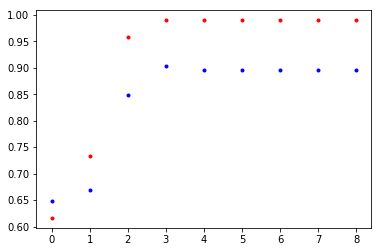

In [47]:
#Plot train and val scores
plt.plot(range(len(depths)),trainscores,".",color="red")
plt.plot(range(len(depths)),valscores,".",color="blue")

In [48]:
#Best validation score
print("Best accuracy: {}\nBest depth: {}".format(max(valscores),depths[valscores.index(max(valscores))]))

Best accuracy: 0.9034013605442177
Best depth: 20


In [56]:
rfmodel=RandomForestClassifier(n_estimators=100,max_depth=20).fit(Xtrain,ytrain)

In [57]:
print("Train Accuracy: {}\nValidation Accuracy: {}\nTest Accuracy: {}".format(rfmodel.score(Xtrain,ytrain),
                                                                             rfmodel.score(Xval,yval),
                                                                             rfmodel.score(Xtest,ytest)))

Train Accuracy: 0.989660976196201
Validation Accuracy: 0.8993197278911564
Test Accuracy: 0.9155092592592593


Retrain this model on the trainval set and test on the test set

In [58]:
rfmodel2=RandomForestClassifier(n_estimators=200,max_depth=20).fit(Xtrainval,ytrainval)

In [59]:
print("Train Accuracy: {}\nTest Accuracy: {}".format(rfmodel.score(Xtrainval,ytrainval),rfmodel.score(Xtest,ytest)))

Train Accuracy: 0.9760931753167144
Test Accuracy: 0.9155092592592593
